In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

#### Подбираем значения mean и std для нормализации
Кто-то должен проверить:
* Улучшает ли классификацию
* Правильно ли посчитано
  
[ссылка про нормализацию](https://ru.stackoverflow.com/questions/1218189/%D0%9A%D0%B0%D0%BA%D0%B8%D0%B5-%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B-%D0%BD%D0%B0%D0%B4%D0%BE-%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%82%D1%8C-%D0%B2-transforms-normalize?ysclid=m9sh2cirgu756686841)

In [2]:
train_dataset = datasets.ImageFolder(r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\create data\tmptest", transform=transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

# Gpt считает, что нормализацию нужно вычислять только на train данных
for imgs, _ in train_loader:
    # у нас imgs - [BCHW] размерности, т.е. батч, цвет, высота, ширина
    mean += imgs.mean([0, 2, 3])  # Среднее по H, W
    std += imgs.std([0, 2, 3])    # Стандартное отклонение по H, W
    total_images += imgs.size(0)

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.0056, 0.0055, 0.0052])
Std: tensor([0.0031, 0.0031, 0.0031])


#### Загружаем тренировочный и валидационный наборы:

In [24]:
# Преобразование изображений тренировочного набора
train_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Приводим к одному размеру
    transforms.RandomHorizontalFlip(), # Отзеркаливаем изображение с вероятностью 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Случайно меняем яркость и контраст на +-20%
    transforms.ToTensor(), # Pytorch работает с собственной структурой - тензорами (это аналог матриц из numpy)
    transforms.Normalize(mean, std)
])

# Минимальные трансформации для валидации
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\create data\tmptest", transform=train_transform)
val_dataset = datasets.ImageFolder(r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\create data\tmptest2", transform=val_transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2) # очень удобная штука, автоматизирует работу с изображениями
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Посмотрим на классы:
class_names = train_dataset.classes
print("Классы:", class_names)

Классы: ['0occupied', '1empty']


#### Далее вспомогательные функции:
* **compute_metric** считает заданную метрику
* **train_model** обучает модель
* **print_model_summary** выводит краткое текстовое описание модели

In [26]:
# Кто бы мог подумать, что в pytorch нет готового решения для метрик (в keras, например, есть). Так что все вручную:
def compute_metric(y_true, y_pred, metric='accuracy'):
    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'f1':
        return f1_score(y_true, y_pred, average='macro')
    elif metric =='precision':
        return precision_score(y_true, y_pred)
    else:
        raise ValueError(f"Unknown metric: {metric}")

# ЦИкл обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, metric_name='accuracy', scheduler=None):
    train_l, val_l, train_m, val_m = [], [], [], []
    for epoch in range(num_epochs):
        # === TRAINING ===
        model.train() # Перевод модели в режим обучения
        train_loss = 0.0 # Общая ошибка за эпоху
        all_preds, all_labels = [], []

        for imgs, labels in train_loader: # DataLoader автоматически подает изображения батчами (т.е. небольшими наборами, например по 64)
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad() # Обнуляем градиенты с предыдущего шага (т.к. вычисляем новые)
            outputs = model(imgs) 
            loss = criterion(outputs, labels) # criterion хранит функцию потерь, вычисляем ошибки на батче
            loss.backward() # back propagation
            optimizer.step() # обновляем веса модели (оптимизируем)

            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1) # max - берет наибольшее значение, а argmax - позицию элемента с max значением (т.е. номер класса)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader) # Средняя ошибка
        train_metric = compute_metric(all_labels, all_preds, metric=metric_name) # см выше - это наша метрика

        # === VALIDATION ===
        model.eval() # Режим валидации (например, Dropout не работает и градиенты не вычисляются)
        val_loss = 0.0
        val_preds, val_labels = [], []

        # Технически градиенты не вычисляются, но вроде как все равно напрягают процессор, поэтому нужно их выключить совсем (но это не точно):
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_metric = compute_metric(val_labels, val_preds, metric=metric_name)

        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f} | {metric_name}: {train_metric:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | {metric_name}: {val_metric:.4f}")
        train_l.append(train_loss)
        val_l.append(val_loss)
        train_m.append(train_metric)
        val_m.append(val_metric)
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_metric)
            else:
                scheduler.step()
    return train_l, train_m, val_l, val_m

In [27]:
# Это я попросила GPT вывести таки summary (у меня почему-то траблы с torchsummary пакетом)
# Что он тут делает я вообще хз, но выглядит как нужно
def print_model_summary(model, input_size=(3, 64, 64)):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary_list)

            m_key = f"{module_idx}-{class_name}"
            summary_list[m_key] = {
                "input_shape": tuple(input[0].size())[1:],  # (C, H, W)
                "output_shape": tuple(output.size())[1:] if isinstance(output, torch.Tensor) else "multiple",
                "nb_params": sum(p.numel() for p in module.parameters() if p.requires_grad)
            }

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not (module == model):
            hooks.append(module.register_forward_hook(hook))

    device = next(model.parameters()).device
    summary_list = {}
    hooks = []

    model.apply(register_hook)
    dummy_input = torch.rand(1, *input_size).to(device)
    model(dummy_input)

    for h in hooks:
        h.remove()

    # Вывод
    print(f"{'Layer (type)':30} {'Input Shape':20} {'Output Shape':20} {'Param #'}")
    print("=" * 80)
    total_params = 0
    for layer in summary_list:
        info = summary_list[layer]
        total_params += info["nb_params"]
        print(f"{layer:30} {str(info['input_shape']):20} {str(info['output_shape']):20} {info['nb_params']}")
    print("=" * 80)
    print(f"Total trainable parameters: {total_params:,}")

#### Задаем модель нейросети

In [28]:
# Обычная сверточная модель: всего 2 слоя свертки
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)
        #self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1)) # вроде он нужен если изображения разных размеров, но у нас пока одинаковые (условно)

        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
# Здесь нужно подключить видеокарту для вычислений, но у меня пока не получилось
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [30]:
model = SmallCNN().to(device)
print_model_summary(model)

Layer (type)                   Input Shape          Output Shape         Param #
0-Conv2d                       (3, 64, 64)          (16, 64, 64)         448
1-BatchNorm2d                  (16, 64, 64)         (16, 64, 64)         32
2-MaxPool2d                    (16, 64, 64)         (16, 32, 32)         0
3-Conv2d                       (16, 32, 32)         (32, 32, 32)         4640
4-BatchNorm2d                  (32, 32, 32)         (32, 32, 32)         64
5-MaxPool2d                    (32, 32, 32)         (32, 16, 16)         0
6-Dropout                      (8192,)              (8192,)              0
7-Linear                       (8192,)              (64,)                524352
8-Linear                       (64,)                (2,)                 130
Total trainable parameters: 529,666


#### Указываем функцию ошибки и оптимизатор
*P.S.* у меня код переделеан из многоклассовой классификацию в двухклассовую. Но для бинарной классификации обычно делают под ргому: используют binary entropy и выходной слой не вектор из значений вероятности принадлежность к классу 0 и классу 1, а просто вероятность принадлежности к классу 1.  
Если кто хочет, может переделать.

In [31]:
criterion = torch.nn.CrossEntropyLoss() # это функция ошибки
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # это алгоритм оптимизации (Адам - это тот же сохаст. градиентный спуск + улучшения над ним)

#### Скорость обучения будем менять, иначе в какой-то момент шаг алгоритма станет больше расстояния до оптимума и мы будем скакать вокруг

In [32]:
#Будем динамически изменять скорость обучения во время обучения модели:

#Изменяем, если метрика перестала расти:
#scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=0, factor=0.5)

#Изменяем каждые 2 шага
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

#### Обучаем модель

In [33]:
train_loss, train_metric, val_loss, val_metric = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    metric_name='f1',  # или 'accuracy' или 'precision'
    scheduler = scheduler
)

Epoch 1:
  Train Loss: 0.0491 | f1: 0.9841
  Val   Loss: 0.0246 | f1: 0.9908
Epoch 2:
  Train Loss: 0.0200 | f1: 0.9933
  Val   Loss: 0.0172 | f1: 0.9949
Epoch 3:
  Train Loss: 0.0126 | f1: 0.9963
  Val   Loss: 0.0158 | f1: 0.9953
Epoch 4:
  Train Loss: 0.0123 | f1: 0.9965
  Val   Loss: 0.0119 | f1: 0.9966
Epoch 5:
  Train Loss: 0.0099 | f1: 0.9973
  Val   Loss: 0.0133 | f1: 0.9953
Epoch 6:
  Train Loss: 0.0075 | f1: 0.9979
  Val   Loss: 0.0129 | f1: 0.9954
Epoch 7:
  Train Loss: 0.0076 | f1: 0.9980
  Val   Loss: 0.0133 | f1: 0.9956
Epoch 8:
  Train Loss: 0.0064 | f1: 0.9984
  Val   Loss: 0.0114 | f1: 0.9960
Epoch 9:
  Train Loss: 0.0069 | f1: 0.9982
  Val   Loss: 0.0119 | f1: 0.9954
Epoch 10:
  Train Loss: 0.0065 | f1: 0.9983
  Val   Loss: 0.0111 | f1: 0.9964


#### Выведем графики обучения

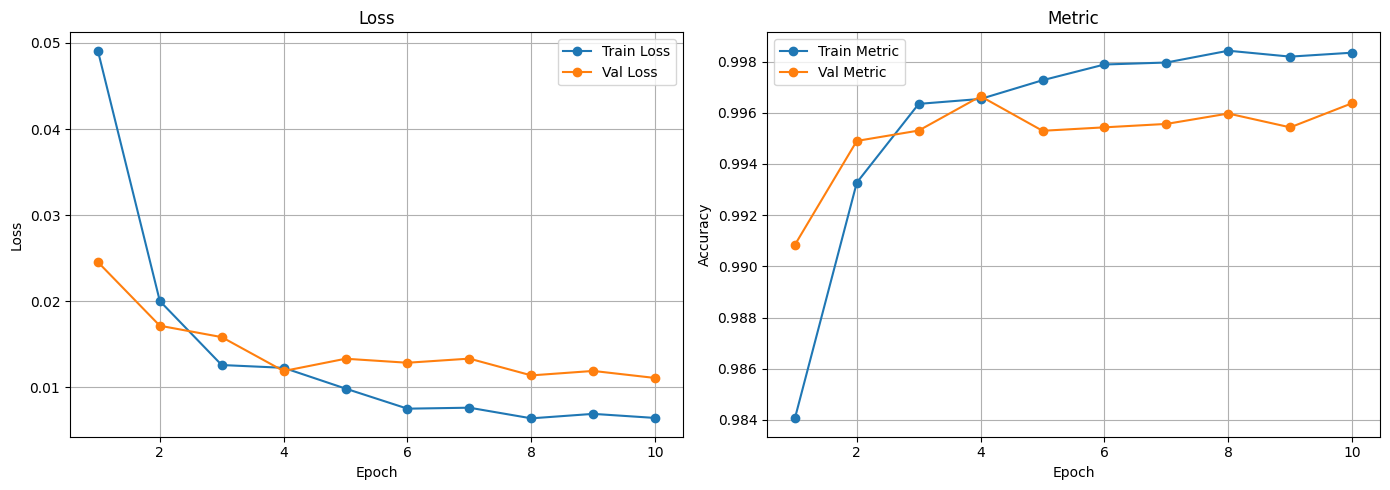

In [34]:
epochs = len(train_loss) + 1

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# График Loss
axs[0].plot(range(1, epochs), train_loss, label='Train Loss', marker='o')
axs[0].plot(range(1, epochs), val_loss, label='Val Loss', marker='o')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# График Метрики
axs[1].plot(range(1, epochs), train_metric, label='Train Metric', marker='o')
axs[1].plot(range(1, epochs), val_metric, label='Val Metric', marker='o')
axs[1].set_title('Metric')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### А теперь проверим модель на тестовых данных

In [45]:
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.ImageFolder(root=r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\create data\tmptest3", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
y_true, y_pred = [], []

# Хранилище ошибок
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad(): # Без вычисления градиентов
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
        for img, pred, label in zip(imgs, preds, labels):
            if pred.item() != label.item():
                wrong_images.append(img.cpu())
                wrong_preds.append(pred.item())
                wrong_labels.append(label.item())

print("Classification Report on test:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report on test:
              precision    recall  f1-score   support

   0occupied       1.00      1.00      1.00      2239
      1empty       1.00      1.00      1.00      1761

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



#### А поточнее

In [36]:
print("Accuracy = ", accuracy_score(y_true, y_pred))
print("F-1 мера = ", f1_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred))

Accuracy =  0.99875
F-1 мера =  0.9985807550383197
Precision =  0.9982973893303064


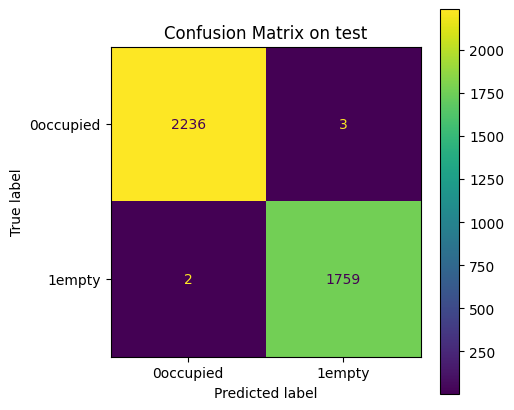

In [46]:
# Вычисляем confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format='d')
plt.title("Confusion Matrix on test")
plt.show()

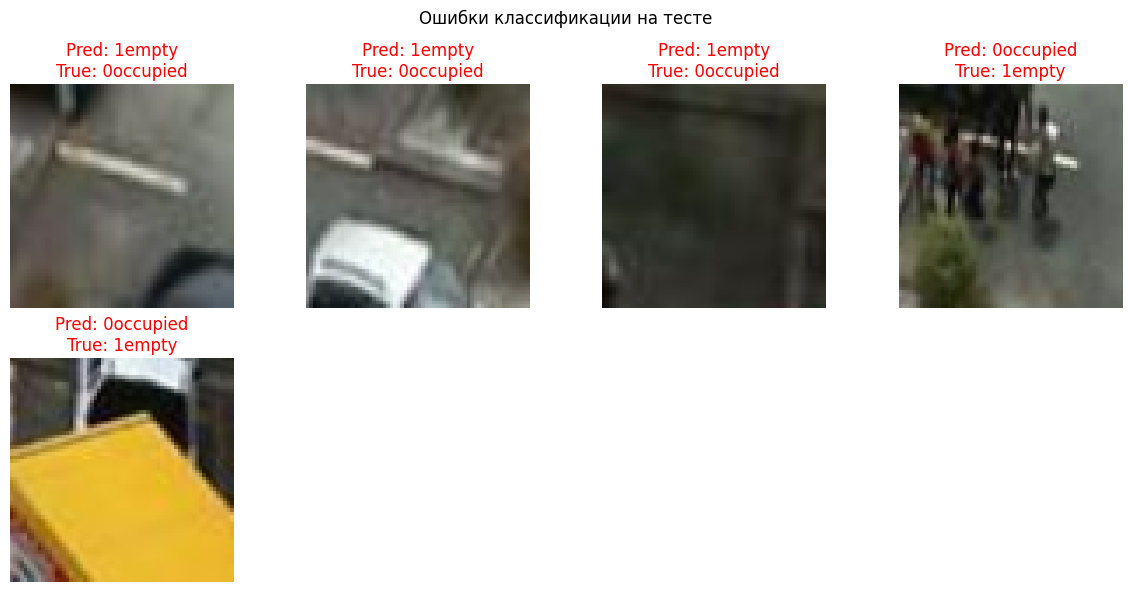

In [47]:
# Визуализация первых N ошибок
N = 8

# Функция для отмены нормализации
def denormalize(tensor, mean, std):
    for i in range(3):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

plt.figure(figsize=(12, 6))
for i in range(min(N, len(wrong_images))):
    img = wrong_images[i]
    img = denormalize(img.clone(), mean, std)
    pred = class_names[wrong_preds[i]]
    label = class_names[wrong_labels[i]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Pred: {pred}\nTrue: {label}", color='red')
    plt.axis("off")

plt.suptitle("Ошибки классификации на тесте")
plt.tight_layout()
plt.show()

In [48]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def make_prediction(img_path):
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    print(f"Модель предсказала класс: {class_names[predicted_class]}")

In [49]:
for i in range(1, 7):
    img_path = r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\доп картинки\empty_lot" + str(i)+".png"
    make_prediction(img_path)
print("_"*40)
for i in range(1, 7):
    img_path = r"C:\Users\1\Downloads\Telegram Desktop\что есть на данный момент\доп картинки\occupied_lot" + str(i)+".png"
    make_prediction(img_path)

Модель предсказала класс: 1empty
Модель предсказала класс: 1empty
Модель предсказала класс: 1empty
Модель предсказала класс: 1empty
Модель предсказала класс: 1empty
Модель предсказала класс: 1empty
________________________________________
Модель предсказала класс: 0occupied
Модель предсказала класс: 0occupied
Модель предсказала класс: 0occupied
Модель предсказала класс: 1empty
Модель предсказала класс: 0occupied
Модель предсказала класс: 1empty


#### Сохраняем веса модели

In [50]:
torch.save(model.state_dict(), 'model1_weights.pth')

#### Если нужно загрузить модель

In [51]:
model = SmallCNN()
model.load_state_dict(torch.load('model1_weights.pth'))
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)